# Image slicer spot simulation
*A. Bolton, 2023 Oct*

*This notebook implements an initial model for an image slicer of a particular type. Just one slice right now, plus the various intermediate planes after it. Can tip/tilt PSF around to create more complex simulations.*

In [1]:
# Imports:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import poppy
from poppy.poppy_core import PlaneType
import astropy.units as u
import astropy.io.fits as fits
import skimage.measure

In [2]:
# Function to create the slicer optical system:

def make_slicer_sys(diam = 6.5*u.m,               # diameter of primary mirror
                    sec_rad = 0.65*u.m,           # radius of secondary obscuration
                    n_supp = 3,                   # number of secondary support struts
                    supp_wid = 0.15*u.m,          # width of secondary support struts
                    npix = 2048,                  # number of pixels across pupil
                    pupil_factor = 10,            # beam diameter as multiple of pupil diameter (for unresolved pupil handling)
                    tel_fratio = 159.,            # delivered f-ratio of beam from telescope/magnifier
                    slice_wid_arcsec = 0.020,     # width of slice in arcseconds
                    slice_len_arcsec = 1.08,      # length of slice in arcseconds
                    micropup_diam = 0.64e-3*u.m,  # diameter of micropupil at pupil mirror
                    pmirror_wid = 2.e-3*u.m,      # pupil mirror width
                    pmirror_len = 3.e-3*u.m,      # pupil mirror length
                    pseudoslit_mag = 0.35,        # (de)magnification factor of pseudoslit relative to slicer
                    pseudoslit_wid = 1.e-3*u.m,   # pseudoslit mirror width
                    pseudoslit_len = 2.e-3*u.m,   # pseudoslit mirror length
                    spec_pupil_factor = 2.0,      # spectrograph oversize factor relative to telescope pupil
                    spectrograph_mag = 0.74,      # (de)magnification factor of spectrograph relative to pseudoslit
                    specap_shape = 'square',      # shape of spectrograph acceptance aperture ('square' or 'circle')
                    pix_size = 1.e-6*u.m,         # desired physical size of pixels on the detector
                    fov_pixels = 1500):           # desired FOV in pixels for detector

    # Computed parameters:
    pupil_diam = pupil_factor * diam              # full beam diameter
    tel_flength = diam * tel_fratio               # telescope effective focal length
    tel_arcsec_size = tel_flength / 206265.       # physical size of one arcsecond in telescope focal plane
    pmirror_wid_rel = pmirror_wid / micropup_diam # pupil mirror width in units of bean diameter
    pmirror_len_rel = pmirror_len / micropup_diam # pupil mirror length in units of bean diameter
    pslit_wid_arcsec = pseudoslit_wid / (pseudoslit_mag * tel_arcsec_size)  # pseudoslit length and
    pslit_len_arcsec = pseudoslit_len / (pseudoslit_mag * tel_arcsec_size)  # width in arcsec
    det_pscale = (u.arcsec/u.pixel)*pix_size/(pseudoslit_mag*spectrograph_mag*tel_arcsec_size)
    
    # Hardwired parameters:
    oversample = 1    # Oversampling of Fourier modes: force to 1 to avoid confusion.
                      # (We are already buffering around the pupil explicitly.)
    
    # Pack all these into a dictionary for reference:
    par_dict = {'diam': diam,
                'sec_rad': sec_rad,
                'n_supp': n_supp,
                'supp_wid': supp_wid,
                'npix': npix,
                'pupil_factor': pupil_factor,
                'tel_fratio': tel_fratio,
                'slice_wid_arcsec': slice_wid_arcsec,
                'slice_len_arcsec': slice_len_arcsec,
                'micropup_diam': micropup_diam,
                'pmirror_wid': pmirror_wid,
                'pmirror_len': pmirror_len,
                'pseudoslit_mag': pseudoslit_mag,
                'pseudoslit_len': pseudoslit_len,
                'spec_pupil_factor': spec_pupil_factor,
                'spectrograp_mag': spectrograph_mag,
                'specap_shape': specap_shape,
                'pix_size': pix_size,
                'fov_pixels': fov_pixels,
                '_pupil_diam': pupil_diam,
                '_tel_flength': tel_flength,
                '_tel_arcsec_size': tel_arcsec_size,
                '_pmirror_wid_rel': pmirror_wid_rel,
                '_pmirror_len_rel': pmirror_len_rel,
                '_pslit_wid_arcsec': pslit_wid_arcsec,
                '_pslit_len_arcsec': pslit_len_arcsec,
                '_det_pscale': det_pscale}

    # Create optical system...

    # Telescope:
    osys = poppy.OpticalSystem(pupil_diameter=pupil_diam, npix=npix, oversample=oversample)
    prim_ap = poppy.CircularAperture(radius=diam/2.)
    ttstage = poppy.TipTiltStage(prim_ap, radius=diam/2.)
    osys.add_pupil(ttstage, name='Primary aperture')
    osys.planes[-1].wavefront_display_hint = 'intensity'
    osys.add_pupil(poppy.SecondaryObscuration(secondary_radius=sec_rad, n_supports=n_supp, support_width=supp_wid))
    osys.planes[-1].wavefront_display_hint = 'intensity'
    # Slicer:
    osys.add_image(poppy.ScalarTransmission(planetype=PlaneType.image, name='Telescope focal plane'))
    osys.add_image(poppy.RectangularFieldStop(width=slice_wid_arcsec*u.arcsec, height=slice_len_arcsec*u.arcsec,
                                              name='Slicer aperture'))
    # Pupil mirror:
    osys.add_pupil(poppy.ScalarTransmission(planetype=PlaneType.pupil, name='Slicer pupil'))
    osys.add_pupil(poppy.RectangleAperture(width=pmirror_wid_rel*diam, height=pmirror_len_rel*diam,
                                           name='Pupil mirror aperture'))
    osys.planes[-1].wavefront_display_hint = 'intensity'

    # Pseudoslit:
    osys.add_image(poppy.ScalarTransmission(planetype=PlaneType.image, name='Pseudoslit plane'))
    osys.add_image(poppy.RectangularFieldStop(width=pslit_wid_arcsec*u.arcsec, height=pslit_len_arcsec*u.arcsec,
                                              name='Pseudoslit aperture'))
    # Spectrograph:
    osys.add_pupil(poppy.ScalarTransmission(planetype=PlaneType.pupil, name='Spectrograph pupil'))
    if (specap_shape == 'square'):
        osys.add_pupil(poppy.SquareAperture(size=diam*spec_pupil_factor, name='Spectrograph aperture'))
        osys.planes[-1].wavefront_display_hint = 'intensity'
    elif (specap_shape == 'circle'):
        osys.add_pupil(poppy.CircularAperture(radius=0.5*diam*spec_pupil_factor, name='Spectrograph aperture'))
        osys.planes[-1].wavefront_display_hint = 'intensity'
    else:
        print('Unknown value for specap_shape')
    # Detector:
    osys.add_detector(pixelscale=det_pscale, fov_pixels=fov_pixels)

    # Attach parameter dictionary:
    osys.par_dict = par_dict
    
    return osys

In [3]:
osys = make_slicer_sys(slice_wid_arcsec=0.02)

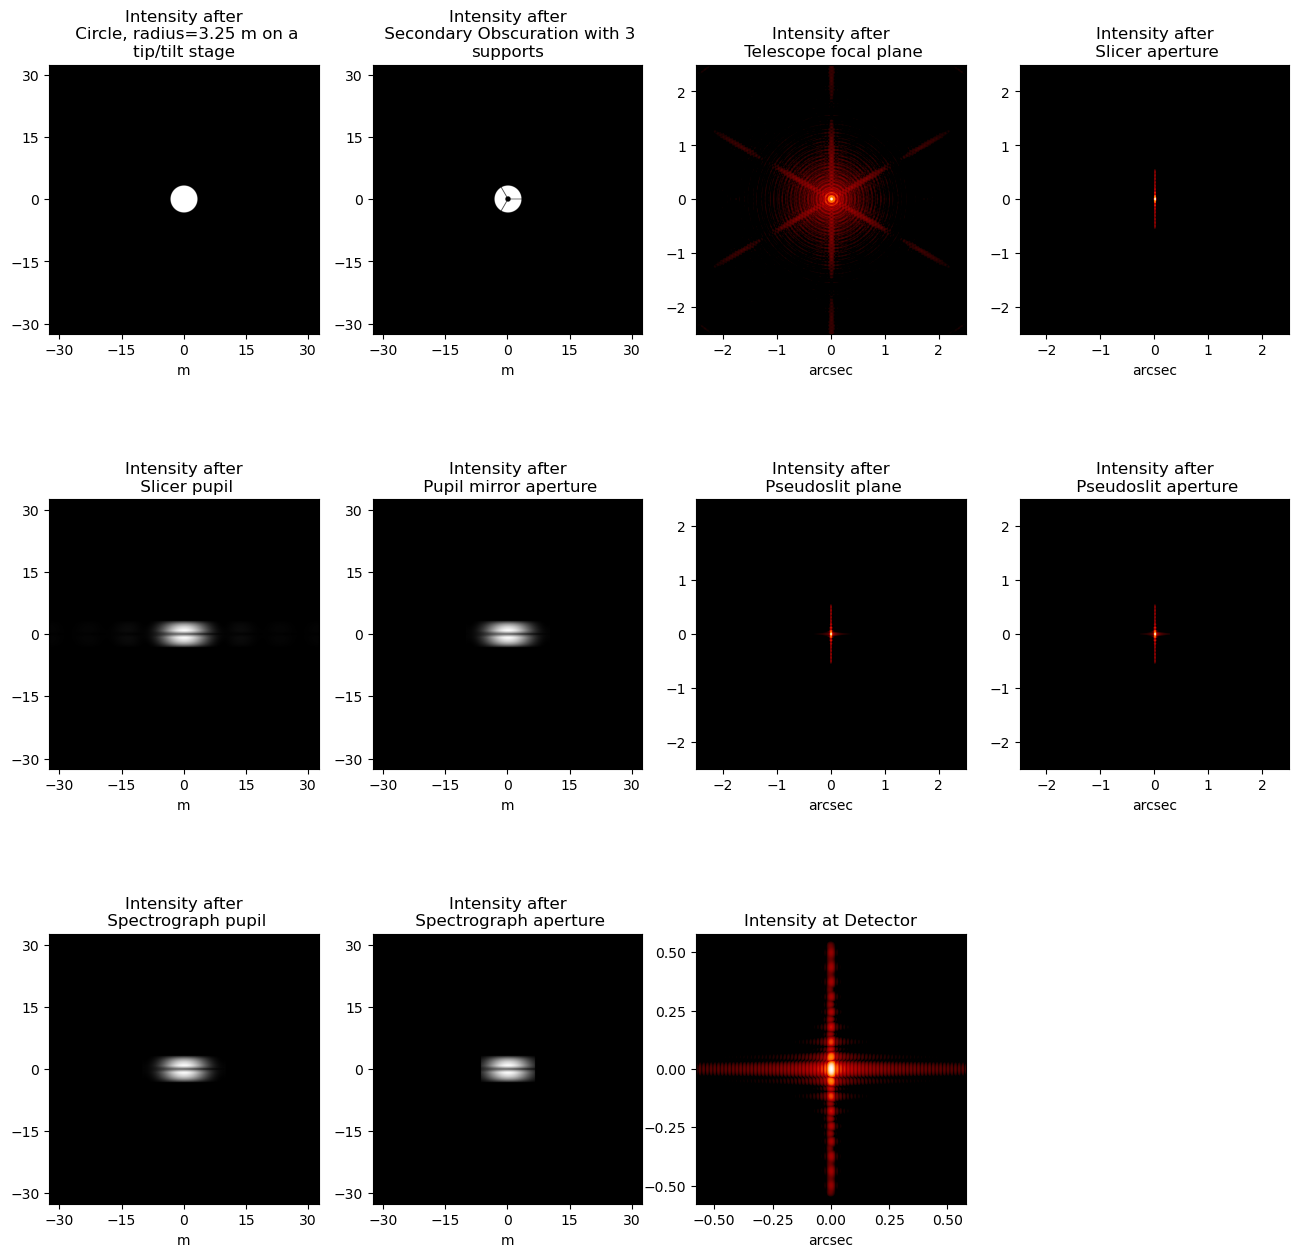

In [4]:
plt.figure(figsize=(16,16))
# tip PSF to center on edge of slice:
osys[0].set_tip_tilt(0.5*osys.par_dict['slice_wid_arcsec'],0.*osys.par_dict['slice_len_arcsec'])
psf, waves = osys.calc_psf(wavelength=1.*u.micron, return_intermediates=True, display_intermediates=True)

### Closer look at the slit image (first 10x oversampled, then pixelized)

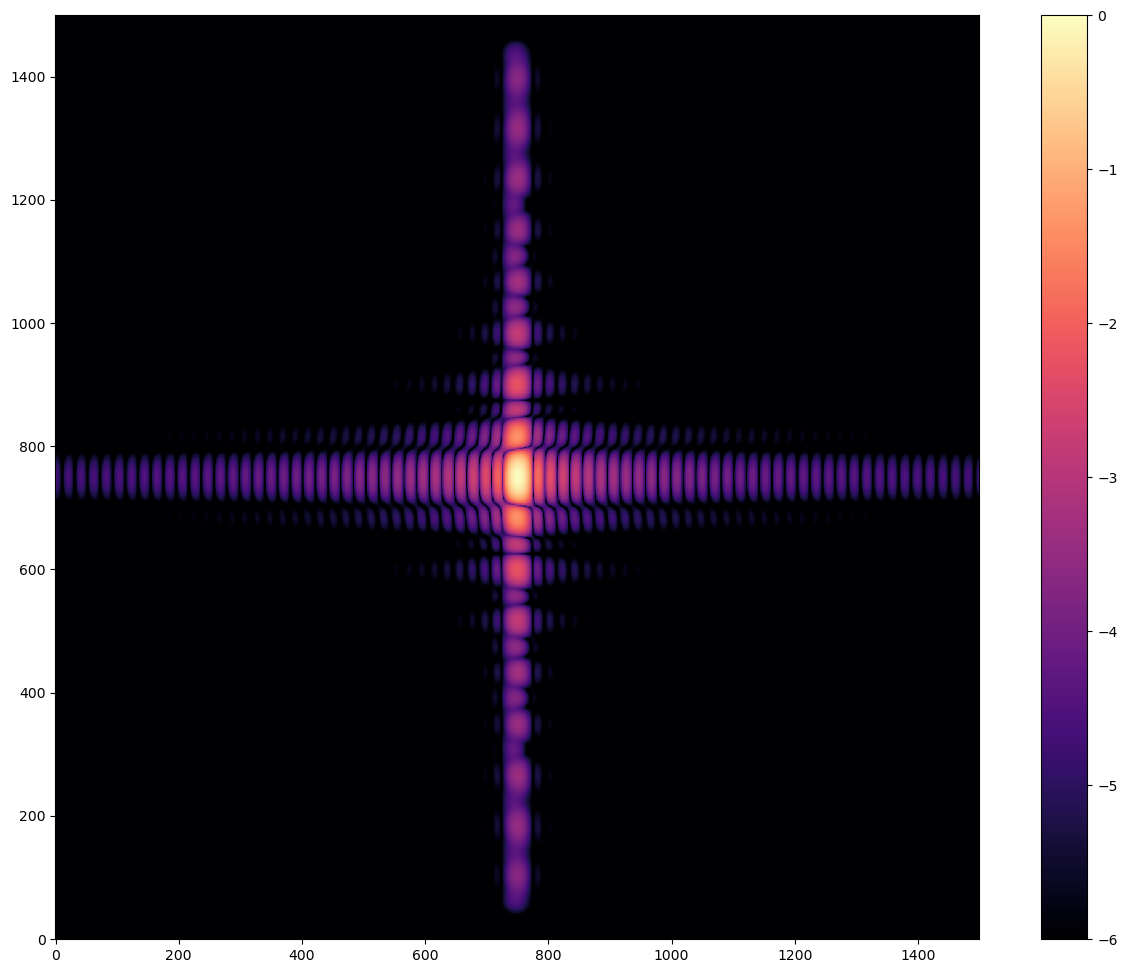

In [5]:
plt.figure(figsize=(16,12))
plot_im = waves[-1].intensity
plot_im /= plot_im.max()
plt.imshow(np.log10(plot_im), origin='lower', cmap='magma', interpolation='nearest', vmin=-6, vmax=0)
plt.colorbar()

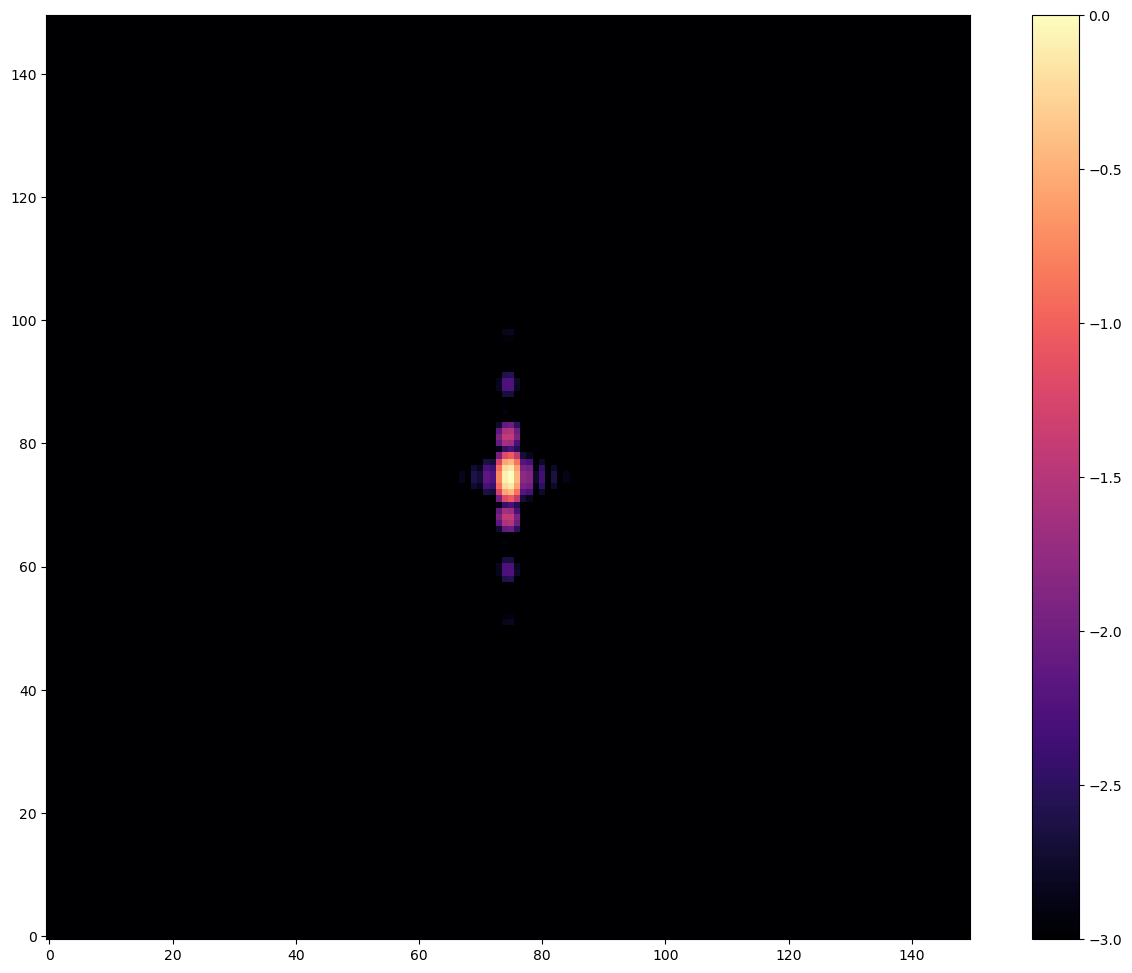

In [6]:
pix_im = skimage.measure.block_reduce(waves[-1].intensity, block_size=10, func=np.sum)
pix_im /= pix_im.max()
plt.figure(figsize=(16,12))
plt.imshow(np.log10(pix_im), origin='lower', cmap='magma', interpolation='nearest', vmin=-3, vmax=0)
plt.colorbar()

### How much light is lost at the pupil mirror?

0.9220105821903767


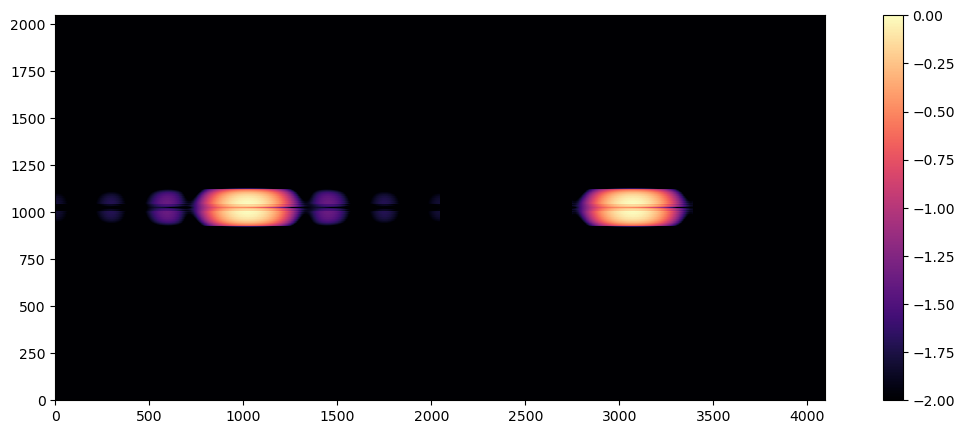

In [7]:
plt.figure(figsize=(15,5))
plot_im = np.hstack([waves[4].intensity,waves[5].intensity])
plot_im /= plot_im.max()
plt.imshow(np.log10(np.maximum(plot_im,1.e-6)),
           origin='lower', cmap='magma', interpolation='nearest', vmin=-2, vmax=0)
plt.colorbar()
print(waves[5].intensity.sum()/waves[4].intensity.sum())

### How much light is lost within the spectrograph?

0.9540576243035962


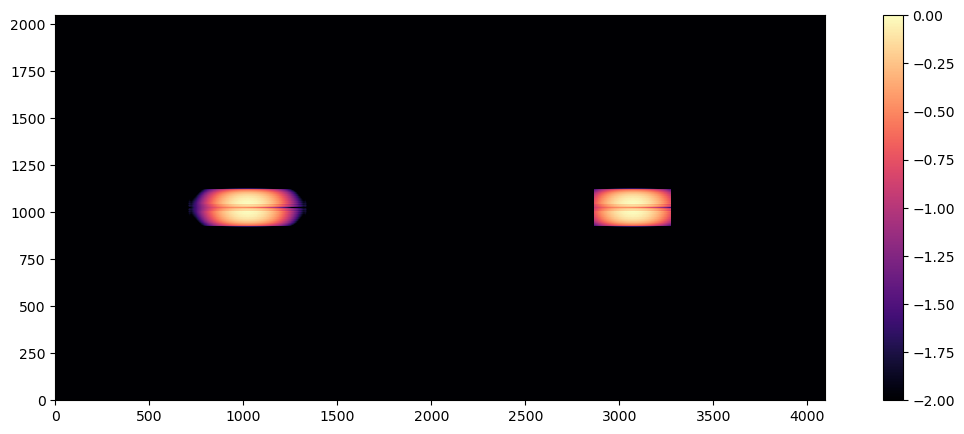

In [8]:
plt.figure(figsize=(15,5))
plot_im = np.hstack([waves[8].intensity,waves[9].intensity])
plot_im /= plot_im.max()
plt.imshow(np.log10(np.maximum(plot_im,1.e-6)),
           origin='lower', cmap='magma', interpolation='nearest', vmin=-2, vmax=0)
plt.colorbar()
print(waves[9].intensity.sum()/waves[8].intensity.sum())